In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/MyDrive/DL/ex1_208144477_206556318'

/content/drive/MyDrive/DL/ex1_208144477_206556318


In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.cuda.is_available()

if not device:
    print('CUDA is unavailable. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

CUDA is available. Training on GPU


In [4]:
batch_size = 64
valid_size = 0.2 # percentage of training set, to be used as validation for model choice

In [5]:
# Define a transformation to normalize the data
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_data = datasets.FashionMNIST('~/.data/Fashion_MNIST/', download=True, train=True, transform=transform)

# Download and load the test data
test_data = datasets.FashionMNIST('~/.data/Fashion_MNIST/', download=True, train=False, transform=transform)


100%|██████████| 26421880/26421880 [00:03<00:00, 8298564.62it/s] 


Extracting /root/.data/Fashion_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.data/Fashion_MNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 146786.49it/s]


Extracting /root/.data/Fashion_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.data/Fashion_MNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2654652.10it/s]


Extracting /root/.data/Fashion_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.data/Fashion_MNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4385999.80it/s]

Extracting /root/.data/Fashion_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.data/Fashion_MNIST/FashionMNIST/raw



In [6]:
# obtain training indices that will be used for validation
train_len = len(train_data)
indices = list(range(train_len))
np.random.shuffle(indices)
idx = int(np.floor(valid_size * train_len))
train_idx, val_idx = indices[idx:], indices[:idx]

# define samplers for obtaining training and validation batches at random order without replacement
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
class Lenet5(nn.Module):
    def __init__(self, batch_normalization=False, enable_dropout=False):
        super(Lenet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        self.conv3_bn = nn.BatchNorm2d(120)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.ReLU = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.batch_normalization = batch_normalization
        self.enable_dropout = enable_dropout

    def forward(self, x):

        drop_precent = 0.2
        x = self.conv1(x)
        if self.batch_normalization:
            x = self.conv1_bn(x)
        x = self.ReLU(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        if self.batch_normalization:
            x = self.conv2_bn(x)
        x = self.ReLU(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        if self.batch_normalization:
            x = self.conv3_bn(x)
        x = self.ReLU(x)
        x = x.reshape(x.shape[0], -1)
        if self.enable_dropout:
            x = F.dropout(x, drop_precent, training=self.training) #define dropout
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x

In [8]:

def acc_calc(model, data_loader):
  
    correct_labels = list(range(10))
    total_examples = list(range(10))
    model.eval()
    
    for data, target in data_loader:
        if device:
            data, target = data.cuda(), target.cuda()
        output = model(data) # fwd pass
        _, pred = torch.max(output, 1)
        correct_examples = pred.eq(target.data.view_as(pred)) #get correct classified examples
        correct = np.squeeze(correct_examples.numpy()) if not device else np.squeeze(correct_examples.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(10):
            label = target.data[i]
            correct_labels[label] += correct[i].item()
            total_examples[label] += 1

    return 100. * np.sum(correct_labels) / np.sum(total_examples)


In [9]:
def plot_convergence(epochs, test_accuracy, train_accuracy, title):

    plt.plot(range(epochs), test_accuracy, label = "Test")
    plt.plot(range(epochs), train_accuracy, label = "Train")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def train_test_model(batch_normalization=False, dropout=False, weight_decay=False, title=""):

    num_epochs = 80
    model = Lenet5(enable_dropout=dropout, batch_normalization=batch_normalization)

    x = torch.randn(batch_size,1,32,32)
    output = model(x)


    if device:
        model.cuda()

    criterion = nn.CrossEntropyLoss() #loss definition
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001 if weight_decay is True else 0) #optimizer definition

    val_loss_min = np.Inf
    train_accuracy = []
    test_accuracy = []

    for epoch in range(1, num_epochs+1):

        train_loss = 0.0
        val_loss = 0.0

        # Train the model according to chosen technique
        model.train() #set nn model to training mode
        for data, target in train_loader:
            if device:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data) #fwd pass
            loss = criterion(output, target) #batch loss
            loss.backward() #back pass
            optimizer.step() #optimization parameter step
            train_loss += loss.item()*data.size(0)

        # Validation
        model.eval()
        for data, target in val_loader:
            if device:
                data, target = data.cuda(), target.cuda()

            with torch.no_grad(): #turn off grad computation during evaluation
                output = model(data)

            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)

        # print accuracies
        epoch_train_accuracy = acc_calc(model, train_loader) #(all acc calculated in eval mode so when dropout is used in train, it is overlooked in the acc calculation)
        epoch_test_accuracy = acc_calc(model, test_loader)
        train_accuracy.append(epoch_train_accuracy)
        test_accuracy.append(epoch_test_accuracy)
        print('Epoch: {} \tTraining Loss: {:.6f} \tTrain Accuracy: {:.6f}\tTest Accuracy: {:.6f}'.format(
            epoch, train_loss, epoch_train_accuracy, epoch_test_accuracy))


        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model checkpoint'.format(val_loss_min, val_loss))
            val_loss_min = val_loss

            if batch_normalization == True:
                torch.save(model.state_dict(), 'bn_model.pt')
            elif dropout == True:
                torch.save(model.state_dict(), 'dropout_model.pt')
            elif weight_decay == True:
                torch.save(model.state_dict(), 'wd_model.pt')
            else:
                torch.save(model.state_dict(), 'base_model.pt')

    #Load best model saved to checkpoint (for a specific technique)
    if batch_normalization == True:
        model.load_state_dict(torch.load('bn_model.pt'))
    elif dropout == True:
        model.load_state_dict(torch.load('dropout_model.pt'))
    elif weight_decay == True:
        model.load_state_dict(torch.load('wd_model.pt'))
    else:
        model.load_state_dict(torch.load('base_model.pt'))
    
    # Test (for best model)
    test_loss = 0.0

    model.eval()
    for data, target in test_loader:
        if device:
            data, target = data.cuda(), target.cuda()

        with torch.no_grad():
          output = model(data)

        loss = criterion(output, target) #batch loss
        test_loss += loss.item()*data.size(0)

    #  test loss (over entire test set)
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss for chosen model: {:.6f}\n'.format(test_loss))

    plot_convergence(num_epochs, test_accuracy, train_accuracy, title)
    return (acc_calc(model, test_loader), acc_calc(model, train_loader)), title



Epoch: 1 	Training Loss: 0.572308 	Train Accuracy: 84.015905	Test Accuracy: 81.733746
Validation loss decreased (inf --> 0.462652).  Saving model checkpoint
Epoch: 2 	Training Loss: 0.395871 	Train Accuracy: 87.130550	Test Accuracy: 84.396285
Validation loss decreased (0.462652 --> 0.378399).  Saving model checkpoint
Epoch: 3 	Training Loss: 0.357422 	Train Accuracy: 88.217362	Test Accuracy: 85.572755
Validation loss decreased (0.378399 --> 0.345303).  Saving model checkpoint
Epoch: 4 	Training Loss: 0.339082 	Train Accuracy: 87.886017	Test Accuracy: 85.944272
Epoch: 5 	Training Loss: 0.325046 	Train Accuracy: 88.959576	Test Accuracy: 87.120743
Validation loss decreased (0.345303 --> 0.341331).  Saving model checkpoint
Epoch: 6 	Training Loss: 0.310484 	Train Accuracy: 90.417495	Test Accuracy: 88.173375
Validation loss decreased (0.341331 --> 0.299643).  Saving model checkpoint
Epoch: 7 	Training Loss: 0.302026 	Train Accuracy: 89.542744	Test Accuracy: 85.325077
Epoch: 8 	Training Loss

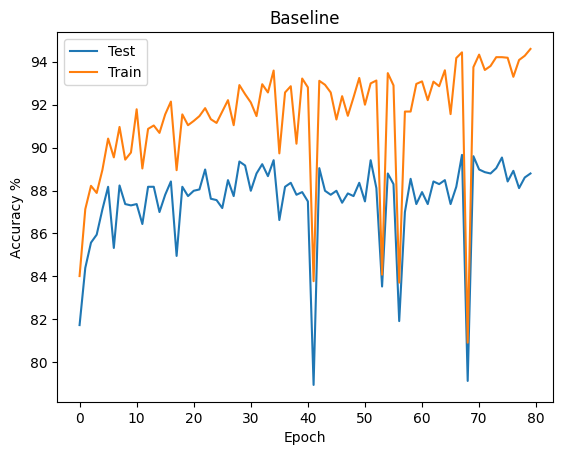

Epoch: 1 	Training Loss: 0.477685 	Train Accuracy: 85.646123	Test Accuracy: 83.777090
Validation loss decreased (inf --> 0.390860).  Saving model checkpoint
Epoch: 2 	Training Loss: 0.348030 	Train Accuracy: 88.283632	Test Accuracy: 87.120743
Validation loss decreased (0.390860 --> 0.319385).  Saving model checkpoint
Epoch: 3 	Training Loss: 0.312706 	Train Accuracy: 90.139165	Test Accuracy: 88.049536
Validation loss decreased (0.319385 --> 0.298650).  Saving model checkpoint
Epoch: 4 	Training Loss: 0.284386 	Train Accuracy: 90.894632	Test Accuracy: 87.739938
Validation loss decreased (0.298650 --> 0.293549).  Saving model checkpoint
Epoch: 5 	Training Loss: 0.269954 	Train Accuracy: 91.371769	Test Accuracy: 89.411765
Validation loss decreased (0.293549 --> 0.269956).  Saving model checkpoint
Epoch: 6 	Training Loss: 0.256212 	Train Accuracy: 91.252485	Test Accuracy: 88.792570
Epoch: 7 	Training Loss: 0.247830 	Train Accuracy: 90.934394	Test Accuracy: 87.616099
Epoch: 8 	Training Loss

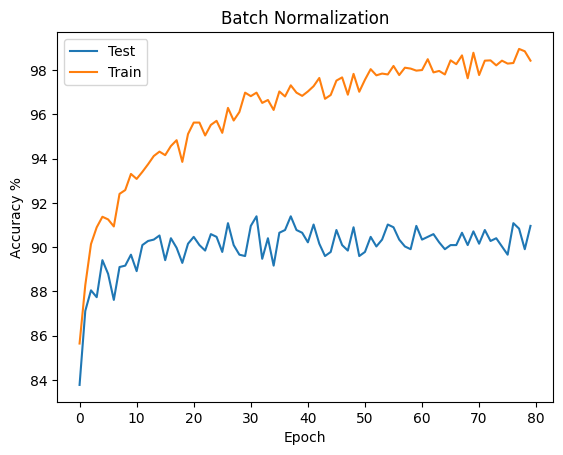

Epoch: 1 	Training Loss: 0.584894 	Train Accuracy: 84.625580	Test Accuracy: 84.148607
Validation loss decreased (inf --> 0.398549).  Saving model checkpoint
Epoch: 2 	Training Loss: 0.410974 	Train Accuracy: 88.137840	Test Accuracy: 86.253870
Validation loss decreased (0.398549 --> 0.367189).  Saving model checkpoint
Epoch: 3 	Training Loss: 0.383696 	Train Accuracy: 87.488403	Test Accuracy: 86.253870
Validation loss decreased (0.367189 --> 0.344507).  Saving model checkpoint
Epoch: 4 	Training Loss: 0.370614 	Train Accuracy: 87.435388	Test Accuracy: 85.944272
Epoch: 5 	Training Loss: 0.355458 	Train Accuracy: 88.840292	Test Accuracy: 85.820433
Epoch: 6 	Training Loss: 0.347267 	Train Accuracy: 87.514911	Test Accuracy: 86.377709
Epoch: 7 	Training Loss: 0.348237 	Train Accuracy: 88.402916	Test Accuracy: 86.377709
Epoch: 8 	Training Loss: 0.338412 	Train Accuracy: 89.609013	Test Accuracy: 86.934985
Validation loss decreased (0.344507 --> 0.317299).  Saving model checkpoint
Epoch: 9 	Tra

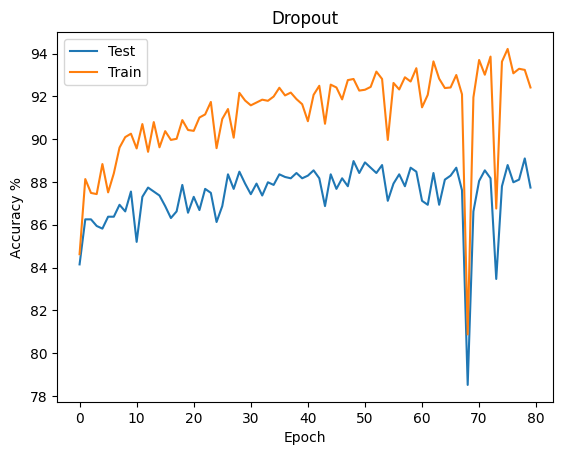

Epoch: 1 	Training Loss: 0.570670 	Train Accuracy: 85.593108	Test Accuracy: 84.086687
Validation loss decreased (inf --> 0.406569).  Saving model checkpoint
Epoch: 2 	Training Loss: 0.411031 	Train Accuracy: 87.117296	Test Accuracy: 86.563467
Validation loss decreased (0.406569 --> 0.378627).  Saving model checkpoint
Epoch: 3 	Training Loss: 0.387717 	Train Accuracy: 87.236581	Test Accuracy: 85.510836
Validation loss decreased (0.378627 --> 0.376169).  Saving model checkpoint
Epoch: 4 	Training Loss: 0.376568 	Train Accuracy: 86.918489	Test Accuracy: 86.996904
Validation loss decreased (0.376169 --> 0.364167).  Saving model checkpoint
Epoch: 5 	Training Loss: 0.363467 	Train Accuracy: 86.998012	Test Accuracy: 87.058824
Validation loss decreased (0.364167 --> 0.356030).  Saving model checkpoint
Epoch: 6 	Training Loss: 0.355237 	Train Accuracy: 86.600398	Test Accuracy: 85.820433
Epoch: 7 	Training Loss: 0.360001 	Train Accuracy: 88.204109	Test Accuracy: 86.687307
Epoch: 8 	Training Loss

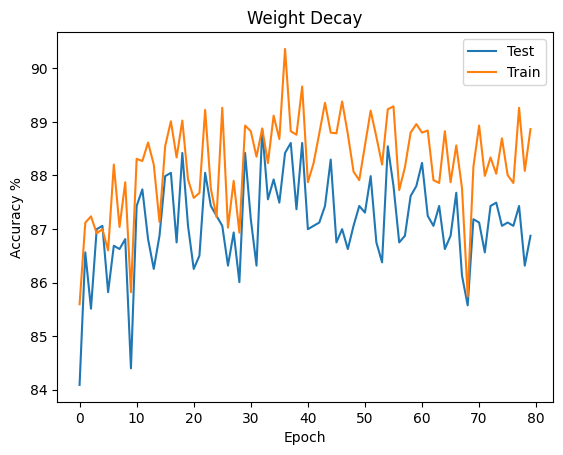

In [15]:
results = [
    train_test_model(batch_normalization=False, dropout=False, weight_decay=False, title="Baseline"),
    train_test_model(batch_normalization=True, dropout=False, weight_decay=False, title="Batch Normalization"),
    train_test_model(batch_normalization=False, dropout=True, weight_decay=False, title="Dropout"),
    train_test_model(batch_normalization=False, dropout=False, weight_decay=True, title="Weight Decay")
]


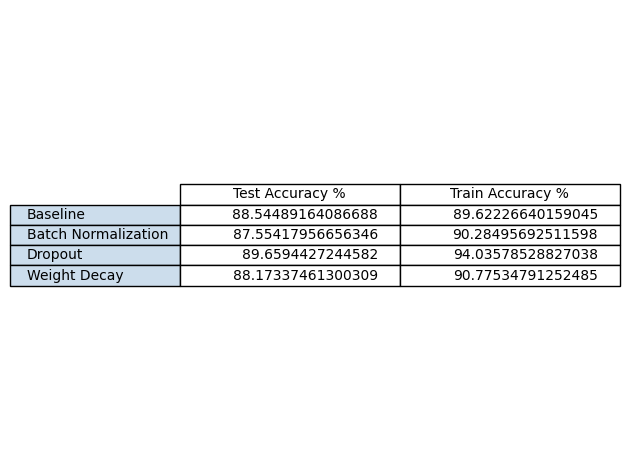

In [16]:
columns = ('Test Accuracy %', 'Train Accuracy %')
rows = [i[1] for i in results]
colors = plt.cm.BuPu(np.linspace(0.2, 0.2, len(rows)))
cell_text = [r[0] for r in results]
colors = colors[::-1]
cell_text.reverse()

fig, ax = plt.subplots()
table = plt.table(cellText=cell_text, rowLabels=rows, rowColours=colors, colLabels=columns, loc="center")

fig.patch.set_visible(False)
ax.axis('off')
fig.tight_layout()
plt.show()